### The Burger's equation (1D case)

The 1d Burger's problem:
\begin{equation}
\begin{split}
    u_t + uu_x - \beta*u_{xx} &= 0 \quad \text{in} \ [0,T]\times[-1,1] \\
    u(x,0)   &= g(x) \quad  \text{in} \ [-1,1] \\
    u(t,-1)  &= u(t,1) = 0
\end{split}
\end{equation}
where $\beta=0.01/\pi$ and
\begin{equation}
    g(x) = -sin(\pi x)
\end{equation}

### (1) Prepare Data

dict_keys(['__header__', '__version__', '__globals__', 'x', 't', 'usol'])


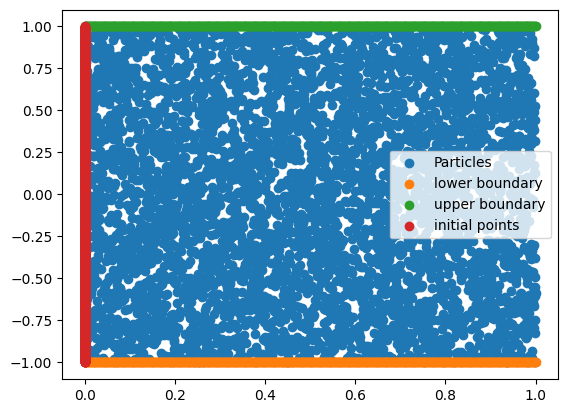

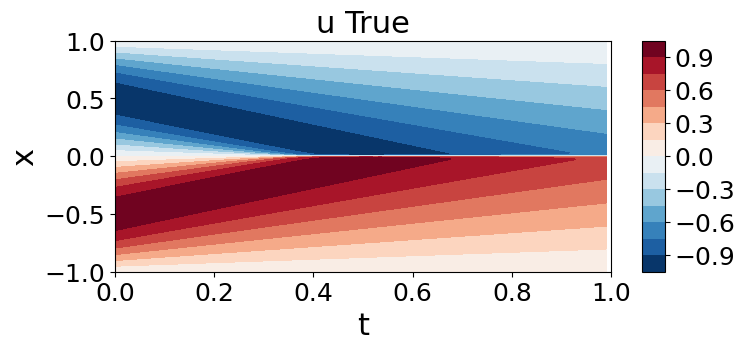

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import scipy.io
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 10086
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'Burgers_1d'
######################################
# Load the problem (wave 1d)
######################################
from Utils.GenPoints_Time import Point1D
pointGen = Point1D(x_lb=[-1.], x_ub=[1.], dataType=dtype, random_seed=random_seed)
data_test = scipy.io.loadmat('../../Problems/Burgers/burgers_1d.mat')
print(data_test.keys())
#
x_mesh, t_mesh = np.array(data_test['x'].T), np.array(data_test['t'].T)
x_mesh, t_mesh = np.meshgrid(x_mesh, t_mesh)
xt_test = torch.tensor(np.vstack([x_mesh.flatten(), t_mesh.flatten()]).T, dtype=dtype)
u_test = torch.tensor(np.array(data_test['usol'].T).reshape(-1,1), dtype=dtype)
######################################
# Generate training data
######################################
Nx_center, Nt_center, N_init, N_bd = 1, 5000, 2000, 500 
#### Particles (centers of CSRBFs)
xc_train, tc_train, R_train = pointGen.weight_centers(
    n_center=Nx_center, nt=Nt_center, Rmax=1e-4, Rmin=1e-4, method='hypercube')
####  (initial points)
xt_init = pointGen.init_point(num_sample=N_init, t_stamp=[0.], method='mesh')
####  (boundary points)
xt_lb, xt_ub = pointGen.boundary_point(num_sample=N_bd)
#########################################
plt.figure()
plt.scatter(tc_train[...,0], xc_train[...,0], label='Particles')
plt.scatter(xt_lb[:,-1], xt_lb[:,0], label='lower boundary')
plt.scatter(xt_ub[:,-1], xt_ub[:,0], label='upper boundary')
plt.scatter(xt_init[:,-1], xt_init[:,0], label='initial points')
plt.legend()
plt.show()
#######
from Utils.PlotFigure import Plot
Plot.show_1dt(xt_test, u_test, title='u True', tT=1.)

### (2) Define the loss class

In [2]:
from torch.autograd import grad, Variable
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=1, n_mesh_or_grid=10, 
    dataType=dtype).get_testFun()

#################################
def f_init(xt_device):
    x = xt_device[...,0:1]
    return - torch.sin(torch.pi * x)

######################################
## The mollifier (to satisfy the boundary condition)
######################################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, xt):
        '''Define the mollifer
        '''
        x= xt[...,0:1]
        u = u * torch.sin(np.pi * x)
        return u

##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_u = solver.model_dict['u']
        self.mollifer = mollifer()
        ######################## 
        self.int_grid = int_grid.to(self.device)
        self.n_grid = int_grid.shape[0]
        self.v = phi.to(self.device)
        self.dv_dr = dphi_dr.to(self.device)
        #
        self.solver.getLoss = torch.nn.MSELoss()
        
    def Loss_pde(self, xc=None, tc=None, R=None, lamda=0.01/torch.pi):
        '''Define the PDE loss
        '''
        # ################################## 
        xc, tc, R = pointGen.weight_centers(n_center=1, nt=5000, Rmax=1e-4, Rmin=1e-4, method='hypercube')
        xc, tc, R = xc.to(self.device), tc.to(self.device), R.to(self.device)
        ################################## 
        nc = xc.shape[0]
        x = self.int_grid * R + xc
        t = tc.repeat(1, self.n_grid, 1)
        x = Variable(x.reshape(-1, 1), requires_grad=True)
        t = Variable(t.reshape(-1, 1), requires_grad=True)
        xt = torch.cat([x,t], dim=-1)
        ##########################################
        v = self.v.repeat((nc,1,1)).reshape(-1,1)
        dv = (self.dv_dr / R).reshape(-1, 1)
        ##########################################
        u = self.model_u(xt)
        u = self.mollifer(u, xt)
        du = self.solver.grad(u, [x, t])
        dux, dut = du[0], du[1]
        ########################################### weawk form
        res1 = (dut*v + u * dux * v 
                + lamda * torch.sum( dux * dv, dim=-1, keepdims=True) )
        res1 = torch.mean(res1.reshape(nc, self.n_grid), dim=-1, keepdim=True)
        ################################################
        res = (res1)**2
        res, indices = torch.sort(res.flatten(), descending=True, dim=0)
        loss_res = torch.sum( res[0:1000] )
        ###########################################
        loss = self.solver.getLoss(res1, torch.zeros_like(res1)) + loss_res
        
        return loss

    def Loss_bd(self):
        ''' '''
        ############### The initial condition
        xt = Variable(xt_init, requires_grad=True).to(self.device)
        u_init = self.model_u(xt)
        u_init = self.mollifer(u_init, xt)
        u_init_true = f_init(xt)
        #
        loss_init = self.solver.getLoss(u_init, u_init_true)
        
        return loss_init
        
    def Error(self):
        ''' '''
        xt = xt_test.to(self.device)
        u = u_test.to(self.device)
        ####### 
        u_pred = self.model_u(xt)
        u_pred = self.mollifer(u_pred, xt)
        error = self.solver.getError(u_pred, u)

        return error

##########################################
from Solvers.ParticleWNN import ParticleWNN_Time
#
solver = ParticleWNN_Time.Solver(device, dtype=dtype)
model_u = solver.getModel([2, 40, 40, 40, 40, 1], 'Tanh_Sin', netType='FCNet')

### (3) Training and predicting

#### (3.1) Train the model

In [3]:
model_dict = {'u': model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', step_size=4000, lbfgs=False, max_iter=1000)
solver.train(LossClass, xc_train, tc_train, R_train, batch_size_in=int(np.ceil(xc_train.shape[0]/50)), 
             w_pde=10, w_bd=1000., epochs=20000, epoch_show=100, **{'save_path':f'saved_models/'})
# solver.train_lbfgs(LossClass, xc_train, tc_train, R_train, epochs=200, 
#                    w_pde=50, w_bd=1000, epoch_show=5, **{'save_path':f'saved_models/'})

  0%|▏                                       | 100/20000 [00:43<2:03:30,  2.69it/s]

Epoch:100 Time:43.1558, loss_in:2.225971, loss_bd:0.075141
          lr: 0.001 l2_err 0.4299544394016266


  1%|▍                                       | 200/20000 [01:20<2:03:03,  2.68it/s]

Epoch:200 Time:80.4419, loss_in:1.693486, loss_bd:0.050377
          lr: 0.001 l2_err 0.3252265453338623


  2%|▌                                       | 300/20000 [01:57<2:01:57,  2.69it/s]

Epoch:300 Time:117.6267, loss_in:1.204815, loss_bd:0.036598
          lr: 0.001 l2_err 0.2678913474082947


  2%|▊                                       | 400/20000 [02:34<2:01:24,  2.69it/s]

Epoch:400 Time:154.8009, loss_in:1.048791, loss_bd:0.025426
          lr: 0.001 l2_err 0.23190061748027802


  2%|█                                       | 500/20000 [03:11<2:00:45,  2.69it/s]

Epoch:500 Time:191.9672, loss_in:0.725879, loss_bd:0.022088
          lr: 0.001 l2_err 0.20283688604831696


  3%|█▏                                      | 600/20000 [03:49<2:00:12,  2.69it/s]

Epoch:600 Time:229.1322, loss_in:0.615605, loss_bd:0.018629
          lr: 0.001 l2_err 0.1840512901544571


  4%|█▍                                      | 700/20000 [04:26<1:59:26,  2.69it/s]

Epoch:700 Time:266.3038, loss_in:0.422405, loss_bd:0.015752
          lr: 0.001 l2_err 0.17151539027690887


  4%|█▌                                      | 800/20000 [05:03<1:58:49,  2.69it/s]

Epoch:800 Time:303.4807, loss_in:0.671675, loss_bd:0.013143
          lr: 0.001 l2_err 0.15798336267471313


  4%|█▊                                      | 900/20000 [05:40<1:58:20,  2.69it/s]

Epoch:900 Time:340.6575, loss_in:0.438950, loss_bd:0.011134
          lr: 0.001 l2_err 0.13794198632240295


  5%|█▉                                     | 1000/20000 [06:17<1:57:38,  2.69it/s]

Epoch:1000 Time:377.8229, loss_in:0.308596, loss_bd:0.010443
          lr: 0.001 l2_err 0.13355028629302979


  6%|██▏                                    | 1100/20000 [06:54<1:57:02,  2.69it/s]

Epoch:1100 Time:414.9984, loss_in:0.445339, loss_bd:0.008979
          lr: 0.001 l2_err 0.12373501062393188


  6%|██▎                                    | 1200/20000 [07:32<1:56:32,  2.69it/s]

Epoch:1200 Time:452.1600, loss_in:0.413199, loss_bd:0.007772
          lr: 0.001 l2_err 0.11181030422449112


  6%|██▌                                    | 1300/20000 [08:09<1:55:48,  2.69it/s]

Epoch:1300 Time:489.3510, loss_in:0.386382, loss_bd:0.007271
          lr: 0.001 l2_err 0.10891735553741455


  7%|██▋                                    | 1400/20000 [08:46<1:55:22,  2.69it/s]

Epoch:1400 Time:526.5198, loss_in:2.152472, loss_bd:0.006557
          lr: 0.001 l2_err 0.10671558976173401


  8%|██▉                                    | 1500/20000 [09:23<1:54:44,  2.69it/s]

Epoch:1500 Time:563.7151, loss_in:0.385236, loss_bd:0.005600
          lr: 0.001 l2_err 0.09760585427284241


  8%|███                                    | 1600/20000 [10:00<1:53:52,  2.69it/s]

Epoch:1600 Time:600.8800, loss_in:0.362170, loss_bd:0.005088
          lr: 0.001 l2_err 0.09254087507724762


  8%|███▎                                   | 1700/20000 [10:38<1:53:23,  2.69it/s]

Epoch:1700 Time:638.0482, loss_in:0.181215, loss_bd:0.004910
          lr: 0.001 l2_err 0.08887170255184174


  9%|███▌                                   | 1800/20000 [11:15<1:52:44,  2.69it/s]

Epoch:1800 Time:675.2301, loss_in:2.401960, loss_bd:0.004585
          lr: 0.001 l2_err 0.08506622165441513


 10%|███▋                                   | 1900/20000 [11:52<1:52:03,  2.69it/s]

Epoch:1900 Time:712.4029, loss_in:1.123853, loss_bd:0.008249
          lr: 0.001 l2_err 0.10605387389659882


 10%|███▉                                   | 2000/20000 [12:29<1:51:31,  2.69it/s]

Epoch:2000 Time:749.5617, loss_in:0.174867, loss_bd:0.003610
          lr: 0.001 l2_err 0.07689236849546432


 10%|████                                   | 2100/20000 [13:06<1:51:15,  2.68it/s]

Epoch:2100 Time:786.7972, loss_in:0.724984, loss_bd:0.003995
          lr: 0.001 l2_err 0.0803554505109787


 11%|████▎                                  | 2200/20000 [13:44<1:50:48,  2.68it/s]

Epoch:2200 Time:824.1129, loss_in:1.134903, loss_bd:0.003859
          lr: 0.001 l2_err 0.07470999658107758


 12%|████▍                                  | 2300/20000 [14:21<1:49:32,  2.69it/s]

Epoch:2300 Time:861.3928, loss_in:0.387396, loss_bd:0.002987
          lr: 0.001 l2_err 0.07007791846990585


 12%|████▋                                  | 2400/20000 [14:58<1:49:00,  2.69it/s]

Epoch:2400 Time:898.5348, loss_in:6.866317, loss_bd:0.003253
          lr: 0.001 l2_err 0.07770730555057526


 12%|████▉                                  | 2500/20000 [15:35<1:48:22,  2.69it/s]

Epoch:2500 Time:935.6949, loss_in:0.215435, loss_bd:0.003111
          lr: 0.001 l2_err 0.07143008708953857


 13%|█████                                  | 2600/20000 [16:12<1:47:48,  2.69it/s]

Epoch:2600 Time:972.8514, loss_in:1.488710, loss_bd:0.002728
          lr: 0.001 l2_err 0.0722137913107872


 14%|█████▎                                 | 2700/20000 [16:50<1:47:07,  2.69it/s]

Epoch:2700 Time:1010.0072, loss_in:1.986542, loss_bd:0.004244
          lr: 0.001 l2_err 0.0869230329990387


 14%|█████▍                                 | 2800/20000 [17:27<1:46:32,  2.69it/s]

Epoch:2800 Time:1047.1758, loss_in:0.508136, loss_bd:0.002277
          lr: 0.001 l2_err 0.059722959995269775


 14%|█████▋                                 | 2900/20000 [18:04<1:45:49,  2.69it/s]

Epoch:2900 Time:1084.3178, loss_in:0.755573, loss_bd:0.002900
          lr: 0.001 l2_err 0.07063322514295578


 15%|█████▊                                 | 3000/20000 [18:41<1:45:12,  2.69it/s]

Epoch:3000 Time:1121.4609, loss_in:1.285367, loss_bd:0.002814
          lr: 0.001 l2_err 0.07120727002620697


 16%|██████                                 | 3100/20000 [19:18<1:44:40,  2.69it/s]

Epoch:3100 Time:1158.5963, loss_in:7.849208, loss_bd:0.002032
          lr: 0.001 l2_err 0.08219440281391144


 16%|██████▏                                | 3200/20000 [19:55<1:43:58,  2.69it/s]

Epoch:3200 Time:1195.7445, loss_in:0.184663, loss_bd:0.001770
          lr: 0.001 l2_err 0.05455487594008446


 16%|██████▍                                | 3300/20000 [20:32<1:43:22,  2.69it/s]

Epoch:3300 Time:1232.8904, loss_in:0.314772, loss_bd:0.002143
          lr: 0.001 l2_err 0.055619727820158005


 17%|██████▋                                | 3400/20000 [21:10<1:42:44,  2.69it/s]

Epoch:3400 Time:1270.0362, loss_in:0.163455, loss_bd:0.001522
          lr: 0.001 l2_err 0.04948386177420616


 18%|██████▊                                | 3500/20000 [21:47<1:42:08,  2.69it/s]

Epoch:3500 Time:1307.1812, loss_in:0.489499, loss_bd:0.001607
          lr: 0.001 l2_err 0.051673054695129395


 18%|███████                                | 3600/20000 [22:24<1:41:31,  2.69it/s]

Epoch:3600 Time:1344.3325, loss_in:0.281913, loss_bd:0.001663
          lr: 0.001 l2_err 0.05130637809634209


 18%|███████▏                               | 3700/20000 [23:01<1:40:54,  2.69it/s]

Epoch:3700 Time:1381.4762, loss_in:0.384573, loss_bd:0.001499
          lr: 0.001 l2_err 0.04925232008099556


 19%|███████▍                               | 3800/20000 [23:38<1:40:18,  2.69it/s]

Epoch:3800 Time:1418.6181, loss_in:16.299452, loss_bd:0.005870
          lr: 0.001 l2_err 0.09522167593240738


 20%|███████▌                               | 3900/20000 [24:15<1:39:39,  2.69it/s]

Epoch:3900 Time:1455.7652, loss_in:1.294783, loss_bd:0.002805
          lr: 0.001 l2_err 0.07028854638338089


 20%|███████▊                               | 4000/20000 [24:52<1:39:05,  2.69it/s]

Epoch:4000 Time:1492.9071, loss_in:0.228292, loss_bd:0.001077
          lr: 0.0005 l2_err 0.04244515672326088


 20%|███████▉                               | 4100/20000 [25:30<1:38:25,  2.69it/s]

Epoch:4100 Time:1530.0516, loss_in:0.111024, loss_bd:0.000807
          lr: 0.0005 l2_err 0.035170819610357285


 21%|████████▏                              | 4200/20000 [26:07<1:37:46,  2.69it/s]

Epoch:4200 Time:1567.2016, loss_in:0.051141, loss_bd:0.000798
          lr: 0.0005 l2_err 0.03383099287748337


 22%|████████▍                              | 4300/20000 [26:44<1:37:17,  2.69it/s]

Epoch:4300 Time:1604.3356, loss_in:0.034965, loss_bd:0.000720
          lr: 0.0005 l2_err 0.03223879262804985


 22%|████████▌                              | 4400/20000 [27:21<1:36:31,  2.69it/s]

Epoch:4400 Time:1641.4725, loss_in:0.054850, loss_bd:0.000637
          lr: 0.0005 l2_err 0.03035702370107174


 22%|████████▊                              | 4500/20000 [27:58<1:35:58,  2.69it/s]

Epoch:4500 Time:1678.6287, loss_in:0.283022, loss_bd:0.000566
          lr: 0.0005 l2_err 0.02928873337805271


 23%|████████▉                              | 4600/20000 [28:35<1:35:24,  2.69it/s]

Epoch:4600 Time:1715.7874, loss_in:0.750441, loss_bd:0.000749
          lr: 0.0005 l2_err 0.03371623903512955


 24%|█████████▏                             | 4700/20000 [29:12<1:34:44,  2.69it/s]

Epoch:4700 Time:1752.9483, loss_in:0.065870, loss_bd:0.000561
          lr: 0.0005 l2_err 0.02966613881289959


 24%|█████████▎                             | 4800/20000 [29:50<1:34:06,  2.69it/s]

Epoch:4800 Time:1790.0903, loss_in:0.028401, loss_bd:0.000463
          lr: 0.0005 l2_err 0.024635611101984978


 24%|█████████▌                             | 4900/20000 [30:27<1:33:25,  2.69it/s]

Epoch:4900 Time:1827.2284, loss_in:0.121174, loss_bd:0.000443
          lr: 0.0005 l2_err 0.02500668354332447


 25%|█████████▊                             | 5000/20000 [31:04<1:32:51,  2.69it/s]

Epoch:5000 Time:1864.3630, loss_in:0.051844, loss_bd:0.000420
          lr: 0.0005 l2_err 0.024531133472919464


 26%|█████████▉                             | 5100/20000 [31:41<1:32:15,  2.69it/s]

Epoch:5100 Time:1901.4981, loss_in:0.108023, loss_bd:0.000407
          lr: 0.0005 l2_err 0.025390971451997757


 26%|██████████▏                            | 5200/20000 [32:18<1:31:34,  2.69it/s]

Epoch:5200 Time:1938.6382, loss_in:0.050510, loss_bd:0.000342
          lr: 0.0005 l2_err 0.021658005192875862


 26%|██████████▎                            | 5300/20000 [32:55<1:30:57,  2.69it/s]

Epoch:5300 Time:1975.7715, loss_in:0.267129, loss_bd:0.000376
          lr: 0.0005 l2_err 0.0234860647469759


 27%|██████████▌                            | 5400/20000 [33:32<1:30:22,  2.69it/s]

Epoch:5400 Time:2012.9030, loss_in:0.682913, loss_bd:0.000346
          lr: 0.0005 l2_err 0.02282574027776718


 28%|██████████▋                            | 5500/20000 [34:10<1:29:48,  2.69it/s]

Epoch:5500 Time:2050.0320, loss_in:0.294808, loss_bd:0.000350
          lr: 0.0005 l2_err 0.022308584302663803


 28%|██████████▉                            | 5600/20000 [34:47<1:29:11,  2.69it/s]

Epoch:5600 Time:2087.1687, loss_in:0.042549, loss_bd:0.000289
          lr: 0.0005 l2_err 0.02145792357623577


 28%|███████████                            | 5700/20000 [35:24<1:28:29,  2.69it/s]

Epoch:5700 Time:2124.3104, loss_in:0.077919, loss_bd:0.000346
          lr: 0.0005 l2_err 0.022124582901597023


 29%|███████████▎                           | 5800/20000 [36:01<1:27:53,  2.69it/s]

Epoch:5800 Time:2161.4555, loss_in:0.055144, loss_bd:0.000245
          lr: 0.0005 l2_err 0.01958640292286873


 30%|███████████▌                           | 5900/20000 [36:38<1:27:16,  2.69it/s]

Epoch:5900 Time:2198.5970, loss_in:0.059882, loss_bd:0.000304
          lr: 0.0005 l2_err 0.022147897630929947


 30%|███████████▋                           | 6000/20000 [37:15<1:26:37,  2.69it/s]

Epoch:6000 Time:2235.7373, loss_in:0.031121, loss_bd:0.000257
          lr: 0.0005 l2_err 0.018750565126538277


 30%|███████████▉                           | 6100/20000 [37:52<1:26:03,  2.69it/s]

Epoch:6100 Time:2272.8765, loss_in:0.046126, loss_bd:0.000295
          lr: 0.0005 l2_err 0.021471286192536354


 31%|████████████                           | 6200/20000 [38:30<1:25:24,  2.69it/s]

Epoch:6200 Time:2310.0223, loss_in:0.209061, loss_bd:0.000464
          lr: 0.0005 l2_err 0.0244813971221447


 32%|████████████▎                          | 6300/20000 [39:07<1:24:53,  2.69it/s]

Epoch:6300 Time:2347.1689, loss_in:0.020621, loss_bd:0.000223
          lr: 0.0005 l2_err 0.017518600448966026


 32%|████████████▍                          | 6400/20000 [39:44<1:24:11,  2.69it/s]

Epoch:6400 Time:2384.3214, loss_in:0.058783, loss_bd:0.000184
          lr: 0.0005 l2_err 0.016669228672981262


 32%|████████████▋                          | 6500/20000 [40:21<1:23:33,  2.69it/s]

Epoch:6500 Time:2421.4747, loss_in:0.289343, loss_bd:0.000233
          lr: 0.0005 l2_err 0.02067757025361061


 33%|████████████▊                          | 6600/20000 [40:58<1:22:58,  2.69it/s]

Epoch:6600 Time:2458.6304, loss_in:0.040019, loss_bd:0.000188
          lr: 0.0005 l2_err 0.016358107328414917


 34%|█████████████                          | 6700/20000 [41:35<1:22:26,  2.69it/s]

Epoch:6700 Time:2495.7715, loss_in:0.034759, loss_bd:0.000221
          lr: 0.0005 l2_err 0.017430922016501427


 34%|█████████████▎                         | 6800/20000 [42:12<1:21:50,  2.69it/s]

Epoch:6800 Time:2532.9067, loss_in:0.089872, loss_bd:0.000309
          lr: 0.0005 l2_err 0.02233254164457321


 34%|█████████████▍                         | 6900/20000 [42:50<1:21:04,  2.69it/s]

Epoch:6900 Time:2570.0360, loss_in:0.019032, loss_bd:0.000200
          lr: 0.0005 l2_err 0.016455592587590218


 35%|█████████████▋                         | 7000/20000 [43:27<1:20:26,  2.69it/s]

Epoch:7000 Time:2607.1821, loss_in:0.092498, loss_bd:0.000320
          lr: 0.0005 l2_err 0.024157555773854256


 36%|█████████████▊                         | 7100/20000 [44:04<1:19:48,  2.69it/s]

Epoch:7100 Time:2644.3228, loss_in:0.187125, loss_bd:0.000169
          lr: 0.0005 l2_err 0.017458077520132065


 36%|██████████████                         | 7200/20000 [44:41<1:19:13,  2.69it/s]

Epoch:7200 Time:2681.4565, loss_in:0.115482, loss_bd:0.000178
          lr: 0.0005 l2_err 0.016122277826070786


 36%|██████████████▏                        | 7300/20000 [45:18<1:18:35,  2.69it/s]

Epoch:7300 Time:2718.5982, loss_in:2.722269, loss_bd:0.000620
          lr: 0.0005 l2_err 0.034742068499326706


 37%|██████████████▍                        | 7400/20000 [45:55<1:17:58,  2.69it/s]

Epoch:7400 Time:2755.7335, loss_in:0.015178, loss_bd:0.000164
          lr: 0.0005 l2_err 0.015038248151540756


 38%|██████████████▋                        | 7500/20000 [46:32<1:17:21,  2.69it/s]

Epoch:7500 Time:2792.8795, loss_in:0.148969, loss_bd:0.000225
          lr: 0.0005 l2_err 0.019677704200148582


 38%|██████████████▊                        | 7600/20000 [47:10<1:16:43,  2.69it/s]

Epoch:7600 Time:2830.0218, loss_in:0.049863, loss_bd:0.000137
          lr: 0.0005 l2_err 0.014387407340109348


 38%|███████████████                        | 7700/20000 [47:47<1:16:06,  2.69it/s]

Epoch:7700 Time:2867.1545, loss_in:0.863920, loss_bd:0.000188
          lr: 0.0005 l2_err 0.015501526184380054


 39%|███████████████▏                       | 7800/20000 [48:24<1:15:28,  2.69it/s]

Epoch:7800 Time:2904.2866, loss_in:2.040272, loss_bd:0.000236
          lr: 0.0005 l2_err 0.024784253910183907


 40%|███████████████▍                       | 7900/20000 [49:01<1:14:52,  2.69it/s]

Epoch:7900 Time:2941.4169, loss_in:1.477345, loss_bd:0.000648
          lr: 0.0005 l2_err 0.03375320881605148


 40%|███████████████▌                       | 8000/20000 [49:38<1:14:16,  2.69it/s]

Epoch:8000 Time:2978.5496, loss_in:0.341027, loss_bd:0.000185
          lr: 0.00025 l2_err 0.01727004535496235


 40%|███████████████▊                       | 8100/20000 [50:15<1:13:39,  2.69it/s]

Epoch:8100 Time:3015.6993, loss_in:0.115791, loss_bd:0.000090
          lr: 0.00025 l2_err 0.011013180017471313


 41%|███████████████▉                       | 8200/20000 [50:52<1:13:01,  2.69it/s]

Epoch:8200 Time:3052.8324, loss_in:0.107409, loss_bd:0.000070
          lr: 0.00025 l2_err 0.010235659778118134


 42%|████████████████▏                      | 8300/20000 [51:29<1:12:26,  2.69it/s]

Epoch:8300 Time:3089.9741, loss_in:0.024141, loss_bd:0.000083
          lr: 0.00025 l2_err 0.010322212241590023


 42%|████████████████▍                      | 8400/20000 [52:07<1:11:46,  2.69it/s]

Epoch:8400 Time:3127.1128, loss_in:0.040631, loss_bd:0.000093
          lr: 0.00025 l2_err 0.010910458862781525


 42%|████████████████▌                      | 8500/20000 [52:44<1:11:13,  2.69it/s]

Epoch:8500 Time:3164.2630, loss_in:0.075366, loss_bd:0.000092
          lr: 0.00025 l2_err 0.010194594040513039


 43%|████████████████▊                      | 8600/20000 [53:21<1:10:36,  2.69it/s]

Epoch:8600 Time:3201.4299, loss_in:0.016397, loss_bd:0.000061
          lr: 0.00025 l2_err 0.009455887600779533


 44%|████████████████▉                      | 8700/20000 [53:58<1:09:56,  2.69it/s]

Epoch:8700 Time:3238.6000, loss_in:0.035732, loss_bd:0.000060
          lr: 0.00025 l2_err 0.008853588253259659


 44%|█████████████████▏                     | 8800/20000 [54:35<1:09:24,  2.69it/s]

Epoch:8800 Time:3275.7625, loss_in:0.040862, loss_bd:0.000057
          lr: 0.00025 l2_err 0.009321420453488827


 44%|█████████████████▎                     | 8900/20000 [55:12<1:08:45,  2.69it/s]

Epoch:8900 Time:3312.9206, loss_in:0.012465, loss_bd:0.000061
          lr: 0.00025 l2_err 0.008856585249304771


 45%|█████████████████▌                     | 9000/20000 [55:50<1:08:11,  2.69it/s]

Epoch:9000 Time:3350.0864, loss_in:0.016109, loss_bd:0.000050
          lr: 0.00025 l2_err 0.008282264694571495


 46%|█████████████████▋                     | 9100/20000 [56:27<1:07:30,  2.69it/s]

Epoch:9100 Time:3387.2399, loss_in:0.015015, loss_bd:0.000056
          lr: 0.00025 l2_err 0.00855534989386797


 46%|█████████████████▉                     | 9200/20000 [57:04<1:06:54,  2.69it/s]

Epoch:9200 Time:3424.4024, loss_in:0.006689, loss_bd:0.000053
          lr: 0.00025 l2_err 0.008251243270933628


 46%|██████████████████▏                    | 9300/20000 [57:41<1:06:14,  2.69it/s]

Epoch:9300 Time:3461.5512, loss_in:0.019776, loss_bd:0.000048
          lr: 0.00025 l2_err 0.008800550363957882


 47%|██████████████████▎                    | 9400/20000 [58:18<1:05:37,  2.69it/s]

Epoch:9400 Time:3498.7074, loss_in:0.089558, loss_bd:0.000054
          lr: 0.00025 l2_err 0.009449000470340252


 48%|██████████████████▌                    | 9500/20000 [58:55<1:04:59,  2.69it/s]

Epoch:9500 Time:3535.8535, loss_in:0.015262, loss_bd:0.000048
          lr: 0.00025 l2_err 0.007827820256352425


 48%|██████████████████▋                    | 9600/20000 [59:32<1:04:22,  2.69it/s]

Epoch:9600 Time:3572.9880, loss_in:0.008404, loss_bd:0.000042
          lr: 0.00025 l2_err 0.007392072584480047


 48%|█████████████████▉                   | 9700/20000 [1:00:10<1:03:45,  2.69it/s]

Epoch:9700 Time:3610.1282, loss_in:0.005944, loss_bd:0.000048
          lr: 0.00025 l2_err 0.00830135028809309


 49%|██████████████████▏                  | 9800/20000 [1:00:47<1:03:08,  2.69it/s]

Epoch:9800 Time:3647.2627, loss_in:0.011171, loss_bd:0.000038
          lr: 0.00025 l2_err 0.0072550387121737


 50%|██████████████████▎                  | 9900/20000 [1:01:24<1:02:31,  2.69it/s]

Epoch:9900 Time:3684.3970, loss_in:0.012850, loss_bd:0.000044
          lr: 0.00025 l2_err 0.008339231833815575


 50%|██████████████████                  | 10000/20000 [1:02:01<1:01:55,  2.69it/s]

Epoch:10000 Time:3721.5392, loss_in:0.038634, loss_bd:0.000034
          lr: 0.00025 l2_err 0.006637467537075281


 50%|██████████████████▏                 | 10100/20000 [1:02:38<1:01:15,  2.69it/s]

Epoch:10100 Time:3758.6756, loss_in:0.052037, loss_bd:0.000031
          lr: 0.00025 l2_err 0.006566145457327366


 51%|██████████████████▎                 | 10200/20000 [1:03:15<1:00:38,  2.69it/s]

Epoch:10200 Time:3795.8180, loss_in:0.023998, loss_bd:0.000030
          lr: 0.00025 l2_err 0.006758598145097494


 52%|██████████████████▌                 | 10300/20000 [1:03:52<1:00:03,  2.69it/s]

Epoch:10300 Time:3832.9647, loss_in:0.035989, loss_bd:0.000029
          lr: 0.00025 l2_err 0.0071629732847213745


 52%|███████████████████▊                  | 10400/20000 [1:04:30<59:27,  2.69it/s]

Epoch:10400 Time:3870.1045, loss_in:0.008535, loss_bd:0.000036
          lr: 0.00025 l2_err 0.00711346510797739


 52%|███████████████████▉                  | 10500/20000 [1:05:07<58:57,  2.69it/s]

Epoch:10500 Time:3907.2663, loss_in:0.097039, loss_bd:0.000032
          lr: 0.00025 l2_err 0.006560410838574171


 53%|████████████████████▏                 | 10600/20000 [1:05:44<58:09,  2.69it/s]

Epoch:10600 Time:3944.4033, loss_in:0.007481, loss_bd:0.000034
          lr: 0.00025 l2_err 0.00671825185418129


 54%|████████████████████▎                 | 10700/20000 [1:06:21<57:34,  2.69it/s]

Epoch:10700 Time:3981.7332, loss_in:0.005543, loss_bd:0.000034
          lr: 0.00025 l2_err 0.006939266808331013


 54%|████████████████████▌                 | 10800/20000 [1:06:58<56:56,  2.69it/s]

Epoch:10800 Time:4018.8864, loss_in:0.053375, loss_bd:0.000035
          lr: 0.00025 l2_err 0.006912607233971357


 55%|████████████████████▋                 | 10900/20000 [1:07:36<56:18,  2.69it/s]

Epoch:10900 Time:4056.0355, loss_in:0.012693, loss_bd:0.000029
          lr: 0.00025 l2_err 0.006159055978059769


 55%|████████████████████▉                 | 11000/20000 [1:08:13<55:42,  2.69it/s]

Epoch:11000 Time:4093.1759, loss_in:0.008556, loss_bd:0.000031
          lr: 0.00025 l2_err 0.006448111496865749


 56%|█████████████████████                 | 11100/20000 [1:08:50<55:07,  2.69it/s]

Epoch:11100 Time:4130.3226, loss_in:0.014549, loss_bd:0.000025
          lr: 0.00025 l2_err 0.005973313935101032


 56%|█████████████████████▎                | 11200/20000 [1:09:27<54:28,  2.69it/s]

Epoch:11200 Time:4167.4670, loss_in:0.016617, loss_bd:0.000040
          lr: 0.00025 l2_err 0.007200058549642563


 56%|█████████████████████▍                | 11300/20000 [1:10:04<53:53,  2.69it/s]

Epoch:11300 Time:4204.6157, loss_in:0.259504, loss_bd:0.000065
          lr: 0.00025 l2_err 0.009224846959114075


 57%|█████████████████████▋                | 11400/20000 [1:10:41<53:13,  2.69it/s]

Epoch:11400 Time:4241.7641, loss_in:0.451534, loss_bd:0.000034
          lr: 0.00025 l2_err 0.00818561390042305


 57%|█████████████████████▊                | 11500/20000 [1:11:18<52:45,  2.68it/s]

Epoch:11500 Time:4278.9153, loss_in:0.023793, loss_bd:0.000024
          lr: 0.00025 l2_err 0.005545704625546932


 58%|██████████████████████                | 11600/20000 [1:11:56<52:28,  2.67it/s]

Epoch:11600 Time:4316.1968, loss_in:0.008911, loss_bd:0.000033
          lr: 0.00025 l2_err 0.006548220291733742


 58%|██████████████████████▏               | 11700/20000 [1:12:33<51:50,  2.67it/s]

Epoch:11700 Time:4353.6890, loss_in:0.098989, loss_bd:0.000027
          lr: 0.00025 l2_err 0.006797440815716982


 59%|██████████████████████▍               | 11800/20000 [1:13:10<50:46,  2.69it/s]

Epoch:11800 Time:4390.8920, loss_in:0.049753, loss_bd:0.000025
          lr: 0.00025 l2_err 0.005885271355509758


 60%|██████████████████████▌               | 11900/20000 [1:13:48<50:07,  2.69it/s]

Epoch:11900 Time:4428.0428, loss_in:0.014983, loss_bd:0.000022
          lr: 0.00025 l2_err 0.005946597084403038


 60%|██████████████████████▊               | 12000/20000 [1:14:25<49:38,  2.69it/s]

Epoch:12000 Time:4465.2133, loss_in:0.019367, loss_bd:0.000027
          lr: 0.000125 l2_err 0.005363235250115395


 60%|██████████████████████▉               | 12100/20000 [1:15:02<48:58,  2.69it/s]

Epoch:12100 Time:4502.3910, loss_in:0.018283, loss_bd:0.000018
          lr: 0.000125 l2_err 0.004755993839353323


 61%|███████████████████████▏              | 12200/20000 [1:15:39<48:17,  2.69it/s]

Epoch:12200 Time:4539.5328, loss_in:0.004425, loss_bd:0.000018
          lr: 0.000125 l2_err 0.004768518265336752


 62%|███████████████████████▎              | 12300/20000 [1:16:16<47:38,  2.69it/s]

Epoch:12300 Time:4576.6673, loss_in:0.006105, loss_bd:0.000016
          lr: 0.000125 l2_err 0.004540146328508854


 62%|███████████████████████▌              | 12400/20000 [1:16:53<47:02,  2.69it/s]

Epoch:12400 Time:4613.7959, loss_in:0.004979, loss_bd:0.000015
          lr: 0.000125 l2_err 0.00426095025613904


 62%|███████████████████████▊              | 12500/20000 [1:17:30<46:25,  2.69it/s]

Epoch:12500 Time:4650.9285, loss_in:0.008650, loss_bd:0.000015
          lr: 0.000125 l2_err 0.004114534705877304


 63%|███████████████████████▉              | 12600/20000 [1:18:08<45:47,  2.69it/s]

Epoch:12600 Time:4688.0604, loss_in:0.044693, loss_bd:0.000015
          lr: 0.000125 l2_err 0.004608682822436094


 64%|████████████████████████▏             | 12700/20000 [1:18:45<45:10,  2.69it/s]

Epoch:12700 Time:4725.1972, loss_in:0.008562, loss_bd:0.000012
          lr: 0.000125 l2_err 0.004047284368425608


 64%|████████████████████████▎             | 12800/20000 [1:19:22<44:34,  2.69it/s]

Epoch:12800 Time:4762.3384, loss_in:0.012648, loss_bd:0.000015
          lr: 0.000125 l2_err 0.004225557204335928


 64%|████████████████████████▌             | 12900/20000 [1:19:59<43:56,  2.69it/s]

Epoch:12900 Time:4799.4837, loss_in:0.004342, loss_bd:0.000012
          lr: 0.000125 l2_err 0.0038427389226853848


 65%|████████████████████████▋             | 13000/20000 [1:20:36<43:20,  2.69it/s]

Epoch:13000 Time:4836.6269, loss_in:0.017418, loss_bd:0.000012
          lr: 0.000125 l2_err 0.003719450905919075


 66%|████████████████████████▉             | 13100/20000 [1:21:13<42:42,  2.69it/s]

Epoch:13100 Time:4873.7672, loss_in:0.006414, loss_bd:0.000012
          lr: 0.000125 l2_err 0.003861473174765706


 66%|█████████████████████████             | 13200/20000 [1:21:50<42:05,  2.69it/s]

Epoch:13200 Time:4910.9087, loss_in:0.004324, loss_bd:0.000018
          lr: 0.000125 l2_err 0.004888514988124371


 66%|█████████████████████████▎            | 13300/20000 [1:22:28<41:28,  2.69it/s]

Epoch:13300 Time:4948.0525, loss_in:0.004198, loss_bd:0.000011
          lr: 0.000125 l2_err 0.0035288308281451464


 67%|█████████████████████████▍            | 13400/20000 [1:23:05<40:51,  2.69it/s]

Epoch:13400 Time:4985.1955, loss_in:0.003041, loss_bd:0.000012
          lr: 0.000125 l2_err 0.004054318647831678


 68%|█████████████████████████▋            | 13500/20000 [1:23:42<40:13,  2.69it/s]

Epoch:13500 Time:5022.3282, loss_in:0.004620, loss_bd:0.000010
          lr: 0.000125 l2_err 0.003405320690944791


 68%|█████████████████████████▊            | 13600/20000 [1:24:19<39:37,  2.69it/s]

Epoch:13600 Time:5059.4717, loss_in:0.004996, loss_bd:0.000011
          lr: 0.000125 l2_err 0.0035060904920101166


 68%|██████████████████████████            | 13700/20000 [1:24:56<38:58,  2.69it/s]

Epoch:13700 Time:5096.6141, loss_in:0.011548, loss_bd:0.000010
          lr: 0.000125 l2_err 0.0034219122026115656


 69%|██████████████████████████▏           | 13800/20000 [1:25:33<38:21,  2.69it/s]

Epoch:13800 Time:5133.7378, loss_in:0.053114, loss_bd:0.000013
          lr: 0.000125 l2_err 0.003973088692873716


 70%|██████████████████████████▍           | 13900/20000 [1:26:10<37:45,  2.69it/s]

Epoch:13900 Time:5170.8675, loss_in:0.004247, loss_bd:0.000010
          lr: 0.000125 l2_err 0.0033832157496362925


 70%|██████████████████████████▌           | 14000/20000 [1:26:47<37:07,  2.69it/s]

Epoch:14000 Time:5207.9939, loss_in:0.006127, loss_bd:0.000012
          lr: 0.000125 l2_err 0.0036872904747724533


 70%|██████████████████████████▊           | 14100/20000 [1:27:25<36:30,  2.69it/s]

Epoch:14100 Time:5245.1200, loss_in:0.005655, loss_bd:0.000007
          lr: 0.000125 l2_err 0.0031472318805754185


 71%|██████████████████████████▉           | 14200/20000 [1:28:02<35:54,  2.69it/s]

Epoch:14200 Time:5282.2521, loss_in:0.005107, loss_bd:0.000008
          lr: 0.000125 l2_err 0.003320350544527173


 72%|███████████████████████████▏          | 14300/20000 [1:28:39<35:17,  2.69it/s]

Epoch:14300 Time:5319.3892, loss_in:0.004501, loss_bd:0.000008
          lr: 0.000125 l2_err 0.0032977221999317408


 72%|███████████████████████████▎          | 14400/20000 [1:29:16<34:39,  2.69it/s]

Epoch:14400 Time:5356.5238, loss_in:0.011181, loss_bd:0.000010
          lr: 0.000125 l2_err 0.0035054697655141354


 72%|███████████████████████████▌          | 14500/20000 [1:29:53<34:01,  2.69it/s]

Epoch:14500 Time:5393.6559, loss_in:0.004119, loss_bd:0.000008
          lr: 0.000125 l2_err 0.0031155890319496393


 73%|███████████████████████████▋          | 14600/20000 [1:30:30<33:25,  2.69it/s]

Epoch:14600 Time:5430.7918, loss_in:0.005331, loss_bd:0.000008
          lr: 0.000125 l2_err 0.003010680666193366


 74%|███████████████████████████▉          | 14700/20000 [1:31:07<32:47,  2.69it/s]

Epoch:14700 Time:5467.9206, loss_in:0.015686, loss_bd:0.000008
          lr: 0.000125 l2_err 0.0030399556271731853


 74%|████████████████████████████          | 14800/20000 [1:31:45<32:10,  2.69it/s]

Epoch:14800 Time:5505.0474, loss_in:0.004917, loss_bd:0.000008
          lr: 0.000125 l2_err 0.003131938399747014


 74%|████████████████████████████▎         | 14900/20000 [1:32:22<31:33,  2.69it/s]

Epoch:14900 Time:5542.1742, loss_in:0.016483, loss_bd:0.000009
          lr: 0.000125 l2_err 0.0034794628154486418


 75%|████████████████████████████▌         | 15000/20000 [1:32:59<30:57,  2.69it/s]

Epoch:15000 Time:5579.3139, loss_in:0.057782, loss_bd:0.000007
          lr: 0.000125 l2_err 0.0033637909218668938


 76%|████████████████████████████▋         | 15100/20000 [1:33:36<30:19,  2.69it/s]

Epoch:15100 Time:5616.4463, loss_in:0.002577, loss_bd:0.000008
          lr: 0.000125 l2_err 0.002974206581711769


 76%|████████████████████████████▉         | 15200/20000 [1:34:13<29:42,  2.69it/s]

Epoch:15200 Time:5653.5775, loss_in:0.012105, loss_bd:0.000008
          lr: 0.000125 l2_err 0.003005441976711154


 76%|█████████████████████████████         | 15300/20000 [1:34:50<29:04,  2.69it/s]

Epoch:15300 Time:5690.7095, loss_in:0.002632, loss_bd:0.000007
          lr: 0.000125 l2_err 0.0029317447915673256


 77%|█████████████████████████████▎        | 15400/20000 [1:35:27<28:28,  2.69it/s]

Epoch:15400 Time:5727.8571, loss_in:0.007261, loss_bd:0.000007
          lr: 0.000125 l2_err 0.0028273488860577345


 78%|█████████████████████████████▍        | 15500/20000 [1:36:05<27:51,  2.69it/s]

Epoch:15500 Time:5765.0032, loss_in:0.006532, loss_bd:0.000007
          lr: 0.000125 l2_err 0.0027879332192242146


 78%|█████████████████████████████▋        | 15600/20000 [1:36:42<27:14,  2.69it/s]

Epoch:15600 Time:5802.1514, loss_in:0.010886, loss_bd:0.000008
          lr: 0.000125 l2_err 0.0029487258289009333


 78%|█████████████████████████████▊        | 15700/20000 [1:37:19<26:49,  2.67it/s]

Epoch:15700 Time:5839.4362, loss_in:0.004267, loss_bd:0.000007
          lr: 0.000125 l2_err 0.0030531655065715313


 79%|██████████████████████████████        | 15800/20000 [1:37:56<26:09,  2.68it/s]

Epoch:15800 Time:5876.8017, loss_in:0.011659, loss_bd:0.000007
          lr: 0.000125 l2_err 0.003982758615165949


 80%|██████████████████████████████▏       | 15900/20000 [1:38:33<25:22,  2.69it/s]

Epoch:15900 Time:5913.8413, loss_in:0.008471, loss_bd:0.000006
          lr: 0.000125 l2_err 0.002860577078536153


 80%|██████████████████████████████▍       | 16000/20000 [1:39:10<24:45,  2.69it/s]

Epoch:16000 Time:5950.9727, loss_in:0.006130, loss_bd:0.000006
          lr: 6.25e-05 l2_err 0.002551910700276494


 80%|██████████████████████████████▌       | 16100/20000 [1:39:48<24:08,  2.69it/s]

Epoch:16100 Time:5988.1113, loss_in:0.002966, loss_bd:0.000006
          lr: 6.25e-05 l2_err 0.0024401708506047726


 81%|██████████████████████████████▊       | 16200/20000 [1:40:25<23:33,  2.69it/s]

Epoch:16200 Time:6025.2573, loss_in:0.006572, loss_bd:0.000005
          lr: 6.25e-05 l2_err 0.0023833548184484243


 82%|██████████████████████████████▉       | 16300/20000 [1:41:02<22:53,  2.69it/s]

Epoch:16300 Time:6062.3961, loss_in:0.003099, loss_bd:0.000005
          lr: 6.25e-05 l2_err 0.0022650810424238443


 82%|███████████████████████████████▏      | 16400/20000 [1:41:39<22:17,  2.69it/s]

Epoch:16400 Time:6099.5379, loss_in:0.005169, loss_bd:0.000005
          lr: 6.25e-05 l2_err 0.0022896169684827328


 82%|███████████████████████████████▎      | 16500/20000 [1:42:16<21:44,  2.68it/s]

Epoch:16500 Time:6136.7156, loss_in:0.004933, loss_bd:0.000004
          lr: 6.25e-05 l2_err 0.0022356759291142225


 83%|███████████████████████████████▌      | 16600/20000 [1:42:54<21:07,  2.68it/s]

Epoch:16600 Time:6174.0128, loss_in:0.003244, loss_bd:0.000005
          lr: 6.25e-05 l2_err 0.0021824233699589968


 84%|███████████████████████████████▋      | 16700/20000 [1:43:31<20:31,  2.68it/s]

Epoch:16700 Time:6211.3224, loss_in:0.023071, loss_bd:0.000005
          lr: 6.25e-05 l2_err 0.002182610100135207


 84%|███████████████████████████████▉      | 16800/20000 [1:44:08<19:54,  2.68it/s]

Epoch:16800 Time:6248.6047, loss_in:0.004079, loss_bd:0.000004
          lr: 6.25e-05 l2_err 0.0022470401600003242


 84%|████████████████████████████████      | 16900/20000 [1:44:45<19:14,  2.68it/s]

Epoch:16900 Time:6285.9402, loss_in:0.007267, loss_bd:0.000005
          lr: 6.25e-05 l2_err 0.0024424183648079634


 85%|████████████████████████████████▎     | 17000/20000 [1:45:23<18:34,  2.69it/s]

Epoch:17000 Time:6323.1795, loss_in:0.007755, loss_bd:0.000004
          lr: 6.25e-05 l2_err 0.0020781501661986113


 86%|████████████████████████████████▍     | 17100/20000 [1:46:00<17:57,  2.69it/s]

Epoch:17100 Time:6360.3186, loss_in:0.002683, loss_bd:0.000004
          lr: 6.25e-05 l2_err 0.0020529460161924362


 86%|████████████████████████████████▋     | 17200/20000 [1:46:37<17:20,  2.69it/s]

Epoch:17200 Time:6397.4580, loss_in:0.010627, loss_bd:0.000004
          lr: 6.25e-05 l2_err 0.002179129747673869


 86%|████████████████████████████████▊     | 17300/20000 [1:47:14<16:42,  2.69it/s]

Epoch:17300 Time:6434.6004, loss_in:0.005313, loss_bd:0.000004
          lr: 6.25e-05 l2_err 0.0019532577134668827


 87%|█████████████████████████████████     | 17400/20000 [1:47:51<16:05,  2.69it/s]

Epoch:17400 Time:6471.7459, loss_in:0.002517, loss_bd:0.000004
          lr: 6.25e-05 l2_err 0.0019397905562072992


 88%|█████████████████████████████████▎    | 17500/20000 [1:48:28<15:28,  2.69it/s]

Epoch:17500 Time:6508.8898, loss_in:0.002869, loss_bd:0.000004
          lr: 6.25e-05 l2_err 0.0018896852852776647


 88%|█████████████████████████████████▍    | 17600/20000 [1:49:06<14:51,  2.69it/s]

Epoch:17600 Time:6546.0395, loss_in:0.002101, loss_bd:0.000004
          lr: 6.25e-05 l2_err 0.0019480647752061486


 88%|█████████████████████████████████▋    | 17700/20000 [1:49:43<14:19,  2.68it/s]

Epoch:17700 Time:6583.2590, loss_in:0.003303, loss_bd:0.000004
          lr: 6.25e-05 l2_err 0.002173805143684149


 89%|█████████████████████████████████▊    | 17800/20000 [1:50:20<13:40,  2.68it/s]

Epoch:17800 Time:6620.5686, loss_in:0.003784, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0018929090583696961


 90%|██████████████████████████████████    | 17900/20000 [1:50:57<13:03,  2.68it/s]

Epoch:17900 Time:6657.8789, loss_in:0.008248, loss_bd:0.000004
          lr: 6.25e-05 l2_err 0.0019541606307029724


 90%|██████████████████████████████████▏   | 18000/20000 [1:51:35<12:27,  2.68it/s]

Epoch:18000 Time:6695.2031, loss_in:0.005586, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0018482374725863338


 90%|██████████████████████████████████▍   | 18100/20000 [1:52:12<11:49,  2.68it/s]

Epoch:18100 Time:6732.4941, loss_in:0.003973, loss_bd:0.000004
          lr: 6.25e-05 l2_err 0.0019381887977942824


 91%|██████████████████████████████████▌   | 18200/20000 [1:52:49<10:38,  2.82it/s]

Epoch:18200 Time:6769.6604, loss_in:0.003492, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0018346305005252361


 92%|██████████████████████████████████▊   | 18300/20000 [1:53:25<10:01,  2.83it/s]

Epoch:18300 Time:6805.0955, loss_in:0.003991, loss_bd:0.000004
          lr: 6.25e-05 l2_err 0.00196017581038177


 92%|██████████████████████████████████▉   | 18400/20000 [1:54:00<09:25,  2.83it/s]

Epoch:18400 Time:6840.4834, loss_in:0.004234, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0017748372629284859


 92%|███████████████████████████████████▏  | 18500/20000 [1:54:35<08:50,  2.83it/s]

Epoch:18500 Time:6875.8386, loss_in:0.009992, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.002002231078222394


 93%|███████████████████████████████████▎  | 18600/20000 [1:55:11<08:15,  2.83it/s]

Epoch:18600 Time:6911.3012, loss_in:0.001689, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0018129434902220964


 94%|███████████████████████████████████▌  | 18700/20000 [1:55:46<07:40,  2.82it/s]

Epoch:18700 Time:6946.7127, loss_in:0.007805, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0018683563685044646


 94%|███████████████████████████████████▋  | 18800/20000 [1:56:22<07:04,  2.83it/s]

Epoch:18800 Time:6982.1058, loss_in:0.003418, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0017684010090306401


 94%|███████████████████████████████████▉  | 18900/20000 [1:56:56<06:10,  2.97it/s]

Epoch:18900 Time:7016.1628, loss_in:0.002488, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0016076482133939862


 95%|████████████████████████████████████  | 19000/20000 [1:57:29<05:33,  2.99it/s]

Epoch:19000 Time:7049.5903, loss_in:0.004363, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0018679180648177862


 96%|████████████████████████████████████▎ | 19100/20000 [1:58:03<05:02,  2.97it/s]

Epoch:19100 Time:7083.0224, loss_in:0.004775, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0016221164260059595


 96%|████████████████████████████████████▍ | 19200/20000 [1:58:36<04:28,  2.98it/s]

Epoch:19200 Time:7116.4939, loss_in:0.002357, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0016418149461969733


 96%|████████████████████████████████████▋ | 19300/20000 [1:59:09<03:54,  2.99it/s]

Epoch:19300 Time:7150.0007, loss_in:0.003706, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0018124752677977085


 97%|████████████████████████████████████▊ | 19400/20000 [1:59:43<03:20,  2.99it/s]

Epoch:19400 Time:7183.4542, loss_in:0.003461, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0017609227215871215


 98%|█████████████████████████████████████ | 19500/20000 [2:00:16<02:47,  2.99it/s]

Epoch:19500 Time:7216.9524, loss_in:0.002509, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0017558690160512924


 98%|█████████████████████████████████████▏| 19600/20000 [2:00:50<02:13,  3.00it/s]

Epoch:19600 Time:7250.3570, loss_in:0.007181, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0016311397776007652


 98%|█████████████████████████████████████▍| 19700/20000 [2:01:23<01:40,  3.00it/s]

Epoch:19700 Time:7283.7159, loss_in:0.004424, loss_bd:0.000002
          lr: 6.25e-05 l2_err 0.00160658557433635


 99%|█████████████████████████████████████▌| 19800/20000 [2:01:57<01:06,  3.00it/s]

Epoch:19800 Time:7317.0855, loss_in:0.004863, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0016497843898832798


100%|█████████████████████████████████████▊| 19900/20000 [2:02:30<00:33,  2.99it/s]

Epoch:19900 Time:7350.4304, loss_in:0.003275, loss_bd:0.000003
          lr: 6.25e-05 l2_err 0.0016318138223141432


100%|██████████████████████████████████████| 20000/20000 [2:03:03<00:00,  2.71it/s]

Epoch:20000 Time:7383.8312, loss_in:0.002007, loss_bd:0.000002
          lr: 3.125e-05 l2_err 0.0015614985022693872


The total training time is 7384.1064


#### (3.2) Make prediction

The l2_err is tensor([0.0015])


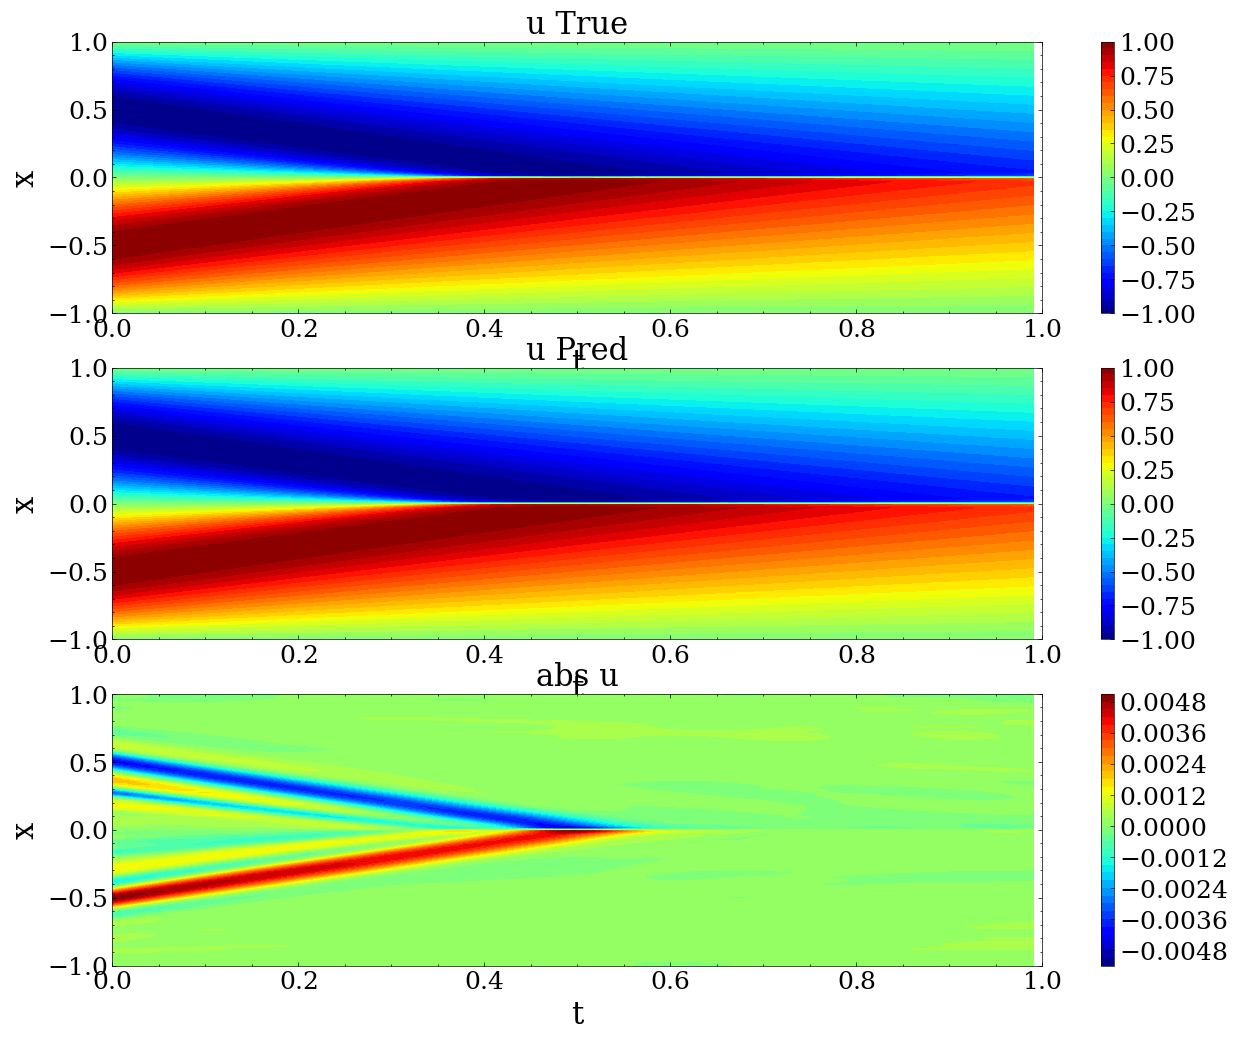

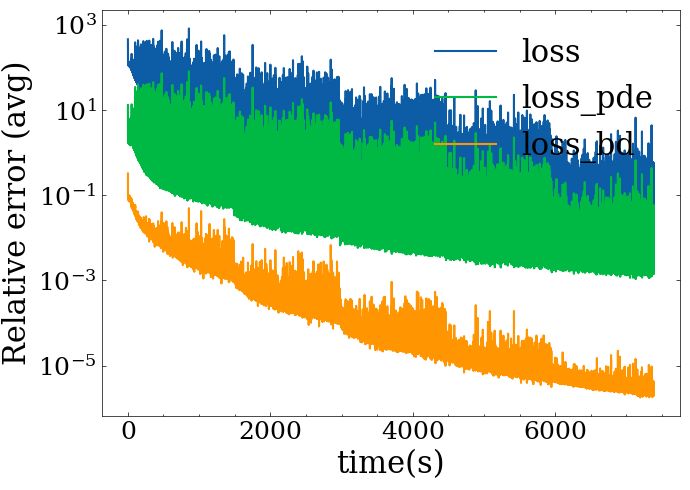

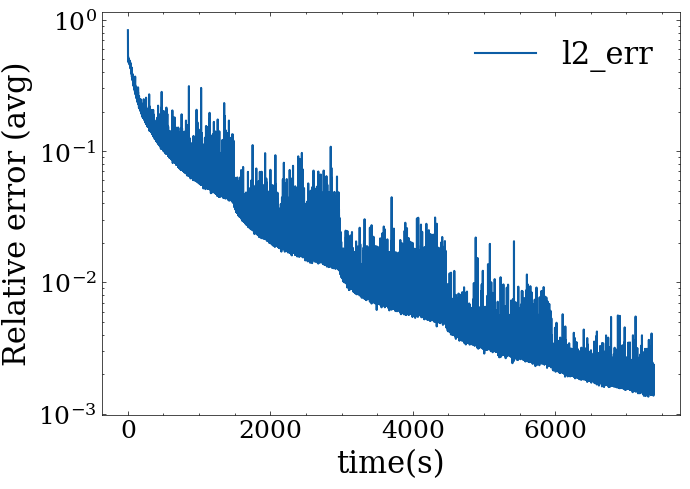

In [3]:
from torch.autograd import grad, Variable
from Utils.PlotFigure import Plot
from Solvers.ParticleWNN import ParticleWNN_Time
from Utils.Losses import * 
myerror = MyLoss().lp_rel
###############################
# load trained model
###############################
solver = ParticleWNN_Time.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/', name='model_particlewnn_final')

###############################
# make prediction
###############################
xt_var = Variable(xt_test, requires_grad=True).to(device)
u_var = model_trained['u'](xt_var)
u_var = mollifer()(u_var, xt_var)
u_var = u_var.detach().cpu()
print('The l2_err is', myerror(u_var, u_test))

###############################
# show the result
###############################
Plot.show_1dt_list(xt_test, [u_test, u_var, u_test-u_var], ['u True', 'u Pred', 'abs u'])
##### show the loss
loss_saved = solver.loadLoss(path=f'saved_models/', name='loss_particlewnn')
Plot.show_error([loss_saved['time']]*3, 
                [loss_saved['loss'], loss_saved['loss_pde'], loss_saved['loss_bd']],
                ['loss', 'loss_pde', 'loss_bd'])
##### show the error
Plot.show_error([loss_saved['time']], [loss_saved['error']], ['l2_err'])